# Markov graph clustering

### Importing libraries

In [110]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn
# Decimal precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# Networkx for plotting the graph
import networkx as nx

# DBscan from sklearn
from sklearn import cluster, datasets
from sklearn.cluster import DBSCAN
from sklearn import metrics
import os
print '\nAll libraries loaded.'


All libraries loaded.


## Utility function definitions

In [111]:
############ Utility functions ############

# Normalization function
def normalize(X):
    return X / X.sum(axis=0)[np.newaxis, :]

# Prune out values that are really close to zero
def prune(X, pruning_threshold):
    for index in np.ndindex(X.shape):
        value = X[index]
        if value <= pruning_threshold:
            X[index] = 0
    return X

# Compare the 2 matrices to check for convergence
def hasConverged(X, Y, convergence_tolerance):
    # Check if the matrices are equal with a tolerance of 0.001
    
    converged = True
    for i in range(0, X.shape[0]):
        for j in range(0, X.shape[1]):
            if abs(X[i][j] - Y[i][j]) > convergence_tolerance:
                converged = False
                break

#   return np.allclose(X, Y, atol=convergence_tolerance)
    return converged

# Load data from file and create an adjacency matrix
def getAdjacencyMatrixFromDataset(filePath, delimiter=' ', datatype=int):
    
    # Read from the file
    edges = np.loadtxt(filePath, delimiter=delimiter, dtype=datatype)
    
    # We need to recalibrate the node indexes to go from 1 to N
#     edgeMap = dict((key, value+1) for (value, key) in enumerate(np.unique(edges)))
#     edges_recalibrated = []
#     for pair in edges:
#         edges_recalibrated.append((edgeMap.get(pair[0]), edgeMap.get(pair[1])))
#     edges = np.array(edges_recalibrated)
        
    # Initialize the adjacency matrix A
    numOfNodes = int(np.amax(edges))
    A = np.zeros((numOfNodes, numOfNodes))
    
    for line in edges:
        A[line[0]-1][line[1]-1] = 1
        A[line[1]-1][line[0]-1] = 1
        
    # Add self-loops
    for i in range(0, A.shape[0]):
        A[i][i] = 1
        
    return A, edges

def getNodeToClusterMapping(clusters):
    nodeToClusterMap = {}
    
    for index, cluster in enumerate(clusters):
        for vertex in cluster:
#             if vertex in nodeToClusterMap:
#                 print 'OVERLAP ===>', vertex
            nodeToClusterMap[vertex] = index+1
    return nodeToClusterMap

# Given a transitional matrix, identify and return clusters
def identifyClusters(T, pruning_threshold):
    clusters = set([])
    X = (T>pruning_threshold)

    for i in range(0, X.shape[0]):
        if X[i][i]:
            # X[i] is an attractor. All nodes attracted to it form a cluster
            newCluster = [index for index, x in enumerate(T[i,:]) if x>0]
            clusters.add(tuple(newCluster))
        
    return list(clusters)

# Make a .clu file using the cluster information
def generateCluFile(clusters, filename):
    # Use the cluster data to make a mapping for node # => cluster #
    mapping = getNodeToClusterMapping(clusters)

    # Write to file
    cluFile = open(filename,'w')
    cluFile.write('*Partition PartitionName\n')
    cluFile.write('*Vertices ' + str(len(mapping)) + '\n')
    for key, value in mapping.iteritems():
        cluFile.write(str(value) + '\n')
    cluFile.close()
    #print 'Finished writing to file', filename
    
# Helper function for modularity: Calculates edge-weight summation between 2 clusters
def edgeWeightSummer(cluster1, cluster2, A):
    sum = 0
    for i in range(len(cluster1)):
        v = cluster1[i]
        if cluster1 == cluster2:
            rangeInner = range(i, len(cluster2))
        else:
            rangeInner = range(len(cluster2))
        for j in rangeInner:
            u = cluster2[j]
            if (int(A[v][u]) == 1):
                sum += 1
    return sum

# Given a set of clusters, find the modularity score
def getModularity(cluster_set, A):
    modularity = 0
    self_sum = 0
    intercluster_sum = 0
    
    # Find intracluster sum
    for cluster in cluster_set:
        self_sum += edgeWeightSummer(cluster, cluster, A)

    # Find intercluster sum
    for i in range(len(cluster_set)):
        cluster1 = cluster_set[i]
        for j in range(i+1, len(cluster_set)):
            cluster2 = cluster_set[j]
            intercluster_sum += edgeWeightSummer(cluster1, cluster2, A)
    
    modularity = self_sum - intercluster_sum
    return modularity

## Functions for drawing graphs (using matplotlib and networkx)

In [112]:
# Graph drawing functions
def draw_graph(graph, labels=None, graph_layout='spring',
               node_size=400, node_color='blue', node_alpha=0.3,
               node_text_size=4,
               edge_color='black', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif', nodespacing=0.02):

    # Define size of the plotted figure
    plt.figure(num=None, figsize=(18.0, 14.0), dpi=580, facecolor='w', edgecolor='k')
    
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G, k=nodespacing)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'circular':
        graph_pos=nx.circular_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    elif graph_layout == 'graphviz':
        graph_pos=nx.graphviz_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    if labels is None:
        labels = range(len(graph))

## Load the datasets
##### We read from the 3 dataset text files, and load the edge information into the edges array. <br>We then use the edge information to generate the adjacency matrices

In [113]:
# AT & T dataset
A_att, edges_att = getAdjacencyMatrixFromDataset("dataset/new_att.txt")
# Physics collaborations
A_physics, edges_physics = getAdjacencyMatrixFromDataset("dataset/new_collaboration.txt")
# Yeast metabolic network
A_yeast, edges_yeast = getAdjacencyMatrixFromDataset("dataset/new_yeast.txt")
print '\nAll datasets loaded.'


All datasets loaded.


## The AT & T dataset (before clustering)

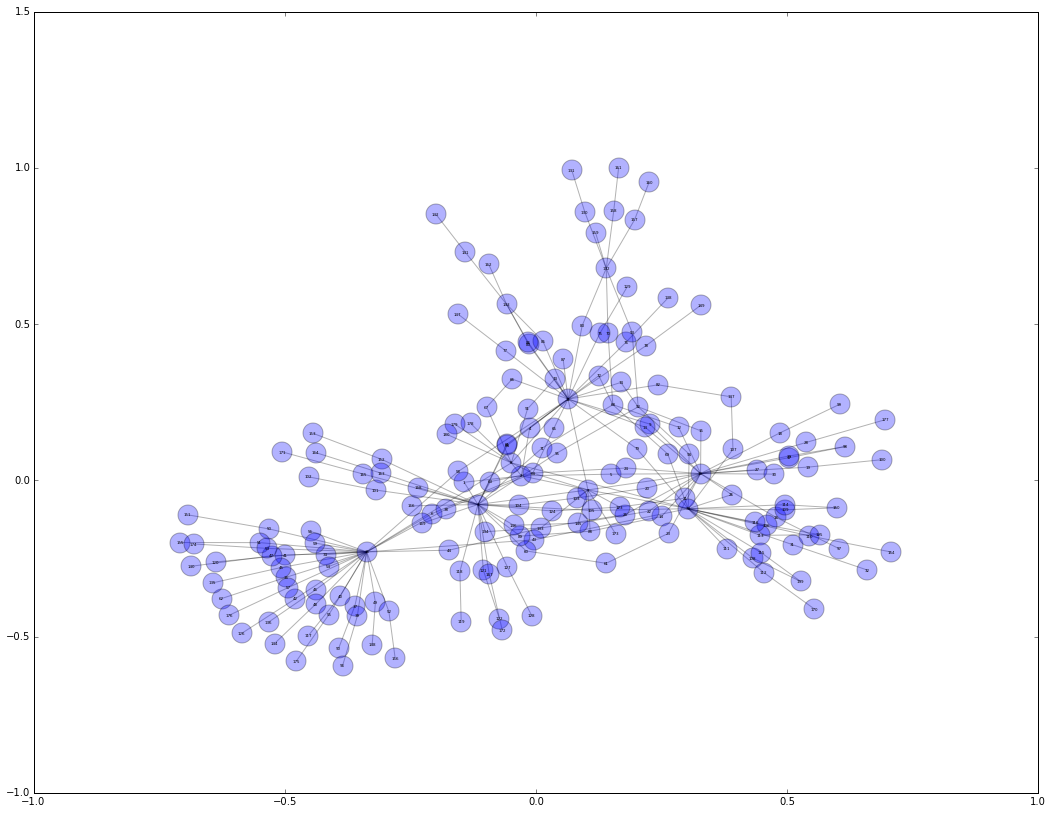

In [114]:
# Draw graph of original values
draw_graph(edges_att, nodespacing=0.02)
plt.show()

## The physics collaborations dataset (before clustering)

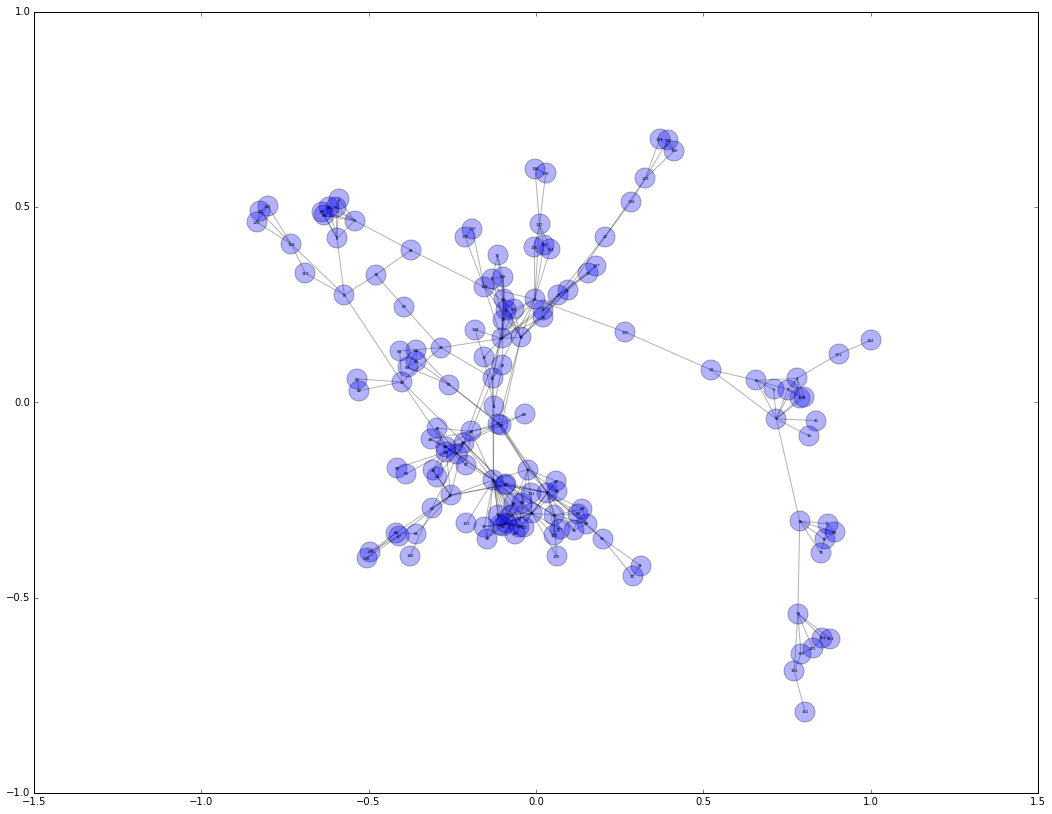

In [115]:
draw_graph(edges_physics, nodespacing=0.02)
plt.show()

## The yeast metabolism dataset (before clustering)

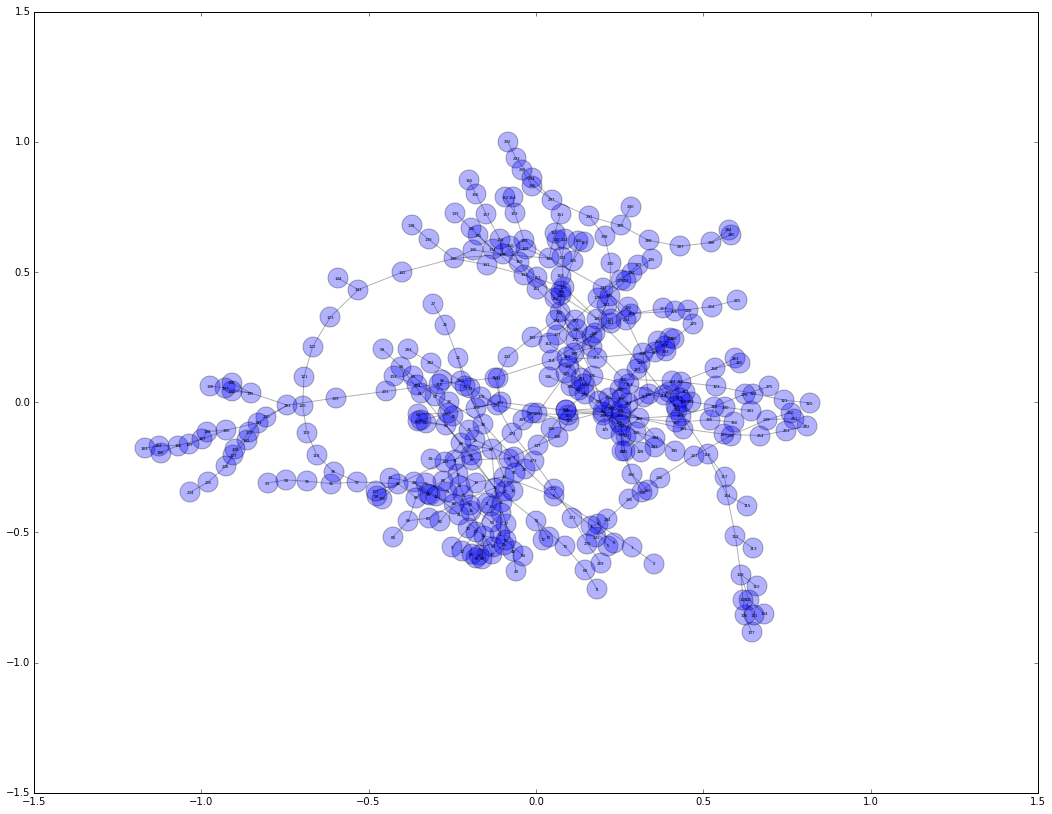

In [116]:
draw_graph(edges_yeast, nodespacing=0.02)
plt.show()

## The Markov clustering algorithm

In [117]:
def applyMclAlgorithm(A, debug_mode=False, R = 2.0, M_matrix_power_parameter = 4, pruning_threshold = 0.0002,  convergence_tolerance = 0.00000001):
    M = np.array(A)

    # Normalize
    M = normalize(M)
    if debug_mode: print '\nAfter normalization\n', M

    # Keep an original copy
    originalM = np.array(M)

    iterationCount = 1
    maxIterations = 50
    while True:
        if debug_mode: print '\n\n======= Iteration', count, '========'
        previousM = np.array(M)

        # Expand
        M = np.linalg.matrix_power(M, M_matrix_power_parameter)
        if debug_mode: print '\nExpanding\n', M

        # Inflate
        M = np.power(M, R)
        if debug_mode: print '\nInflating\n', M

        # Re-normalize
        M = normalize(M)
        if debug_mode: print '\nRenormalizing\n', M

        # Pruning
        M = prune(M, pruning_threshold)
        if debug_mode: print '\nPruning\n', M

        # Check for convergence
        if hasConverged(M, previousM, convergence_tolerance) or iterationCount > maxIterations:
            break

        iterationCount = iterationCount + 1

    clusters = identifyClusters(M, pruning_threshold)
    return clusters, iterationCount

###### MCL parameters ######
R_inflation_param = [1.1, 1.3, 1.5, 1.7, 1.9, 2]
M_expansion_parameter = [2, 3, 4, 5, 6]

###### Function that runs MCL on the datasets for all possible parameter values ######
def runMcl(A, dataset_name):
    
    # Make output folder for .clu files
    folderName = 'output/' + dataset_name + '/'
    if not os.path.exists(folderName):
        os.makedirs(folderName)
    
    # Apply MCL to this adjacency matrix A for all param value combinations.
    for M in M_expansion_parameter:
        for R in R_inflation_param:
            clusters, iterationCount = applyMclAlgorithm(A, R=R, M_matrix_power_parameter=M)
            modularity = getModularity(clusters, A)
            print 'M =', M, ', R =', "{0:.1f}".format(R), ': # of clusters ==> ', '{0:02d}'.format(len(clusters)), ', Iterations:', '{0:02d}'.format(iterationCount), ', Modularity:',modularity
            
            # Make the .clu file
            fileName = folderName + 'M' + str(M) + '_R' + str(int(R*10)) + '.clu';
            generateCluFile(clusters, fileName)
        print ''

## Applying MCL on the datasets
#### We now apply ACL on the 3 datasets, using various values of R (inflation parameter), and M (expansion parameter/matrix power). 

In [118]:
print '\n..:: AT & T dataset ::..'
runMcl(A_att, "att")
print '\n..:: Physics collaboration dataset ::..'
runMcl(A_physics, "physics")
print '\n..:: Yeast metabolic dataset ::..'
runMcl(A_yeast, "yeast")


..:: AT & T dataset ::..
M = 2 , R = 1.1 : # of clusters ==>  01 , Iterations: 45 , Modularity: 408
M = 2 , R = 1.3 : # of clusters ==>  03 , Iterations: 31 , Modularity: 380
M = 2 , R = 1.5 : # of clusters ==>  07 , Iterations: 22 , Modularity: 320
M = 2 , R = 1.7 : # of clusters ==>  10 , Iterations: 18 , Modularity: 304
M = 2 , R = 1.9 : # of clusters ==>  55 , Iterations: 15 , Modularity: 214
M = 2 , R = 2.0 : # of clusters ==>  55 , Iterations: 14 , Modularity: 214

M = 3 , R = 1.1 : # of clusters ==>  01 , Iterations: 48 , Modularity: 408
M = 3 , R = 1.3 : # of clusters ==>  01 , Iterations: 14 , Modularity: 408
M = 3 , R = 1.5 : # of clusters ==>  03 , Iterations: 20 , Modularity: 372
M = 3 , R = 1.7 : # of clusters ==>  06 , Iterations: 17 , Modularity: 330
M = 3 , R = 1.9 : # of clusters ==>  06 , Iterations: 18 , Modularity: 330
M = 3 , R = 2.0 : # of clusters ==>  08 , Iterations: 13 , Modularity: 326

M = 4 , R = 1.1 : # of clusters ==>  01 , Iterations: 49 , Modularity: 4